<a href="https://colab.research.google.com/github/samarakoon-ryan/resampling-unbalanced-datasets/blob/EDA/project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resampling using Credit Card Fraud Detection Dataset

In [7]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

In this project I will show an example of how resampling can be useful for unbalanced datasets in binary classification problems. I'll be using a Logistic Regression Model to demonstrate this. I'm aware that there are a vast amount of tools and libraries to deal with resampling and I strongly recommend that you use a combination of these methods to deal with unbalanced datasets. Here I would like to simply demonstrate the pros and cons of resampling using Sklearn's `resample()`.

## Exploratory Data Analysis

First I'll do some brief data exploration and feature engineering. The dataset is completely numerical so it's pretty straightforward. I'll only be dropping null values.

In [2]:
# Read dataset

detection = pd.read_csv("creditcard.csv")
detection.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [3]:
# Summary statistics for each feature
detection.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,81486.0,37720.489237,15337.372455,0.000000,30993.250000,40377.000000,49669.000000,58953.000000
V1,81486.0,-0.260081,1.887677,-56.407510,-1.021597,-0.252385,1.153571,1.960497
V2,81486.0,-0.038216,1.677784,-72.715728,-0.601897,0.069259,0.721301,18.902453
V3,81486.0,0.678510,1.381217,-33.680984,0.185747,0.763882,1.393502,4.226108
V4,81486.0,0.162804,1.366843,-5.172595,-0.726251,0.182415,1.043373,16.715537
V5,81485.0,-0.277340,1.382213,-42.147898,-0.896819,-0.310669,0.257987,34.801666
V6,81485.0,0.095347,1.305163,-26.160506,-0.643383,-0.154638,0.490507,22.529298
V7,81485.0,-0.114263,1.245783,-31.764946,-0.604700,-0.074211,0.415906,36.677268
V8,81485.0,0.053242,1.230792,-73.216718,-0.141111,0.069391,0.350189,20.007208
V9,81485.0,-0.013048,1.141597,-9.283925,-0.687376,-0.091504,0.618288,10.392889


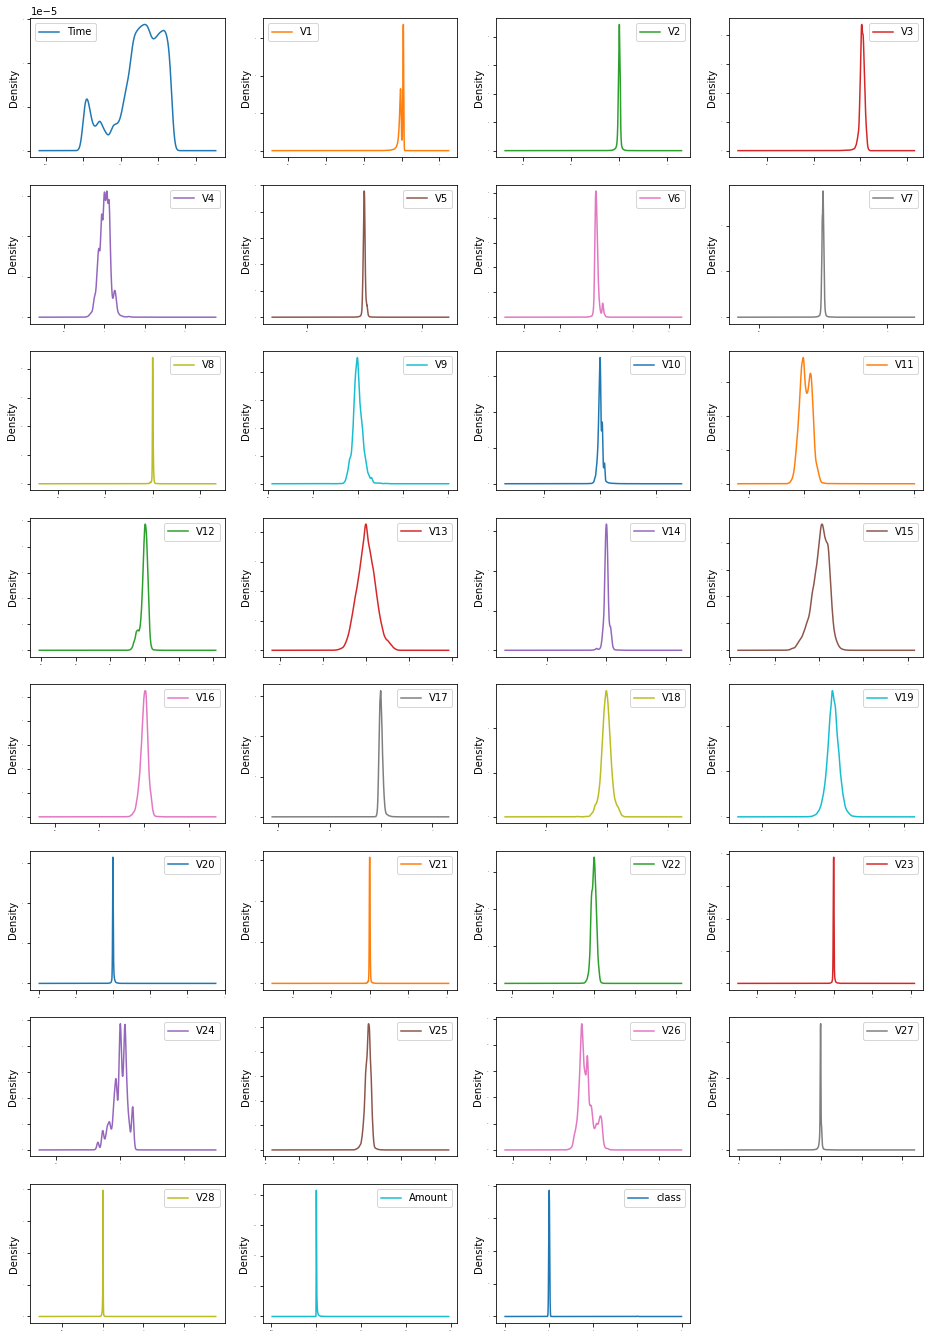

In [4]:
# plot the distribution of all features
detection.plot(kind='density', subplots=True, layout=(8,4), sharex=False, legend=True, 
                                            fontsize=1, figsize=(16,24))
plt.show()

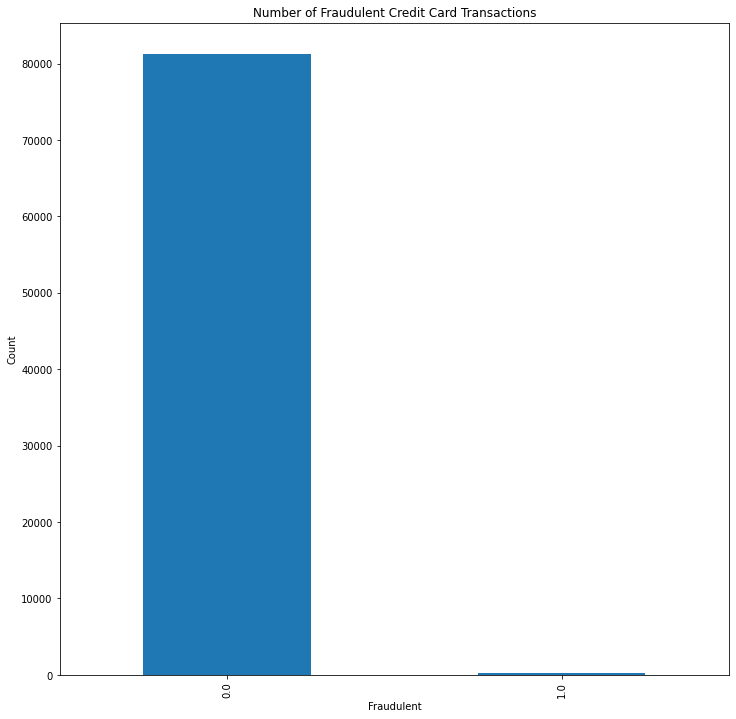

In [5]:
# See distribution of target class
detection['class'].value_counts().plot.bar(figsize=(12,12), xlabel='Fraudulent', ylabel='Count', title='Number of Fraudulent Credit Card Transactions')
plt.show()

In [6]:
# Check for null values and drop
detection.isna().sum()
detection = detection.dropna()